<a href="https://colab.research.google.com/github/RDGopal/IB9LQ0-GenAI/blob/main/Diffusion_Illustration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction to Diffusion Models
Diffusion models are a type of generative model that create new data—such as images—by learning to reverse a process where noise is gradually added to the data. Here’s the basic idea:

* Forward Diffusion: Start with a clear image and add noise step-by-step until it becomes pure noise.
* Backward Diffusion: Train a model to remove the noise step-by-step, transforming the noise back into a meaningful image.

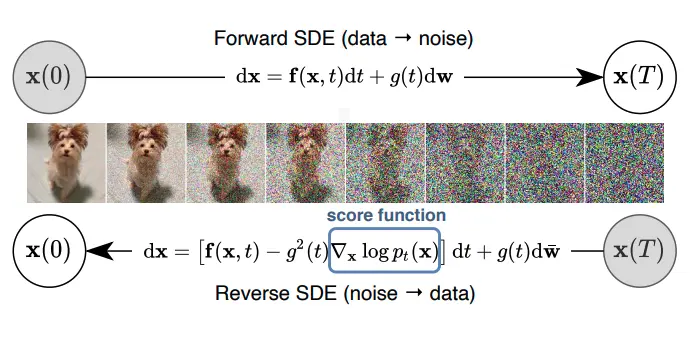

For this class, we will use simple shapes (e.g., circle, triangle, square) instead of complex images. You can input a shape name as text, and the model will generate that shape from noise, making it a hands-on way to understand diffusion models.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

#Image Creation
We will first programmatically create binary images of a circle, triangle, and square in a 28x28 pixel format using Python and NumPy. These images can be represented as NumPy arrays where the shape is filled with 1s and the background is filled with 0s.

##Approach
* Grid Size: We will use a 28x28 grid, common for small image tasks (e.g., MNIST-like datasets).
* Shapes: Each shape will be centered and sized appropriately to fit within the grid.
* Implementation: We will use basic geometry and NumPy array operations to set pixel values.

###Square
Method: Define a square by setting a block of pixels to 1. For simplicity, make it a filled square, centered in the grid.
Size: Choose a width (e.g., 20 pixels), leaving a border around it.

###Circle
Method: Use the circle equation
$$
(
𝑥
−
ℎ
)
2
+
(
𝑦
−
𝑘
)
2
≤
𝑟
2
(x−h)
2
 +(y−k)
2
 ≤r
2
$$

  where
(
ℎ
,
𝑘
)
 is the center and
𝑟 is the radius. Radius of 10 pixels, centered at (14, 14).

###Triangle
* Method: Define three vertices and determine which pixels lie inside the triangle using barycentric coordinates. This ensures a filled triangle.
* Vertices: Place the top at (4, 14), bottom-left at (24, 4), and bottom-right at (24, 24) for an upright triangle.

In [ ]:
# --- Shape Creation Functions ---
def create_square(size=28, square_size=20):
    """Create a binary image of a square."""
    img = np.zeros((size, size))
    start = (size - square_size) // 2
    end = start + square_size
    img[start:end, start:end] = 1
    return img

def create_circle(size=28, radius=10):
    """Create a binary image of a circle."""
    img = np.zeros((size, size))
    center = size // 2
    for i in range(size):
        for j in range(size):
            if (i - center)**2 + (j - center)**2 <= radius**2:
                img[i, j] = 1
    return img

def create_triangle(size=28):
    """Create a binary image of a triangle."""
    img = np.zeros((size, size))
    A = (4, 14)  # Vertex coordinates
    B = (24, 4)
    C = (24, 24)
    for i in range(size):
        for j in range(size):
            if is_inside_triangle(i, j, A, B, C):
                img[i, j] = 1
    return img

def is_inside_triangle(i, j, A, B, C):
    """Check if point (i, j) is inside triangle defined by vertices A, B, C."""
    ax, ay = A
    bx, by = B
    cx, cy = C
    v0x, v0y = cx - ax, cy - ay
    v1x, v1y = bx - ax, by - ay
    v2x, v2y = i - ax, j - ay
    dot00 = v0x**2 + v0y**2
    dot01 = v0x * v1x + v0y * v1y
    dot02 = v0x * v2x + v0y * v2y
    dot11 = v1x**2 + v1y**2
    dot12 = v1x * v2x + v1y * v2y
    denom = dot00 * dot11 - dot01**2
    if denom == 0:
        return False
    u = (dot11 * dot02 - dot01 * dot12) / denom
    v = (dot00 * dot12 - dot01 * dot02) / denom
    return u >= 0 and v >= 0 and (u + v) <= 1

# --- Generate Shapes ---
square = create_square()
circle = create_circle()
triangle = create_triangle()
shapes = {"square": square, "circle": circle, "triangle": triangle}
shape_names = ["square", "circle", "triangle"]
text_encoding = {name: np.eye(3)[i] for i, name in enumerate(shape_names)}

In [ ]:
circle

#Diffusion Model Setup

In [ ]:
# --- Variance Schedule for Diffusion ---
T = 500  # Number of diffusion steps
beta_start = 0.0001
beta_end = 0.02
beta_t = np.linspace(beta_start, beta_end, T)
alpha_t = 1 - beta_t
alpha_bar_t = np.cumprod(alpha_t)

# --- Forward Diffusion Function ---
def get_noisy_image(x_0, t):
    """
    Add noise to the original image x_0 at time step t.
    Args:
        x_0: [batch, 28, 28] - Original image
        t: [batch] - Time steps
    Returns:
        x_t: Noisy image
        epsilon: Noise added
    """
    epsilon = np.random.normal(0, 1, x_0.shape)
    alpha_bar_t_batch = alpha_bar_t[t]
    sqrt_alpha_bar_t = np.sqrt(alpha_bar_t_batch)[:, None, None]
    sqrt_one_minus_alpha_bar_t = np.sqrt(1 - alpha_bar_t_batch)[:, None, None]
    x_t = sqrt_alpha_bar_t * x_0 + sqrt_one_minus_alpha_bar_t * epsilon
    return x_t, epsilon

# --- Denoising Model ---
class DenoisingModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Input has 3 channels: noisy image, text embedding, time channel
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 1, kernel_size=3, padding=1)
        self.text_proj = nn.Linear(3, 28*28)  # Project text encoding to 28x28

    def forward(self, x, t, text):
        """
        Args:
            x: [batch, 1, 28, 28] - Noisy image
            t: [batch] - Time step
            text: [batch, 3] - One-hot text encoding
        Returns:
            Predicted noise: [batch, 1, 28, 28]
        """
        text_emb = self.text_proj(text).view(-1, 1, 28, 28)
        t_channel = (t / T).view(-1, 1, 1, 1) * torch.ones_like(x)
        input = torch.cat([x, text_emb, t_channel], dim=1)  # [batch, 3, 28, 28]
        x = torch.relu(self.conv1(input))
        x = self.conv2(x)
        return x

# --- Initialize Model and Optimizer ---
model = DenoisingModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the Diffusion Model

In [ ]:
# --- Training Loop ---
num_steps = 1000
for step in range(num_steps):
    # Sample a shape
    shape_name = np.random.choice(shape_names)
    x_0 = shapes[shape_name]  # [28, 28]
    text = text_encoding[shape_name]  # [3]
    t = np.random.randint(0, T)  # Single time step

    # Add noise
    x_t, epsilon = get_noisy_image(x_0[None], np.array([t]))  # [1, 28, 28]

    # Convert to PyTorch tensors
    x_t = torch.tensor(x_t, dtype=torch.float32).unsqueeze(0)  # [1, 1, 28, 28]
    epsilon = torch.tensor(epsilon, dtype=torch.float32).unsqueeze(0)  # [1, 1, 28, 28]
    text = torch.tensor(text, dtype=torch.float32).unsqueeze(0)  # [1, 3]
    t_tensor = torch.tensor([t], dtype=torch.float32)  # [1]

    # Forward pass
    pred_epsilon = model(x_t, t_tensor, text)
    loss = F.mse_loss(pred_epsilon, epsilon)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if step % 100 == 0:
        print(f"Step {step}, Loss: {loss.item():.4f}")

# Generation Function

In [ ]:
# --- Generation Function ---
def generate_shape(model, text, T, alpha_t, beta_t, alpha_bar_t):
    """
    Generate a shape from noise using the trained model.
    Args:
        model: Trained DenoisingModel
        text: [3] - Text encoding
        T, alpha_t, beta_t, alpha_bar_t: Diffusion parameters
    Returns:
        Generated image: [28, 28]
    """
    x = np.random.normal(0, 1, (28, 28))  # Start with pure noise
    for t in range(T-1, -1, -1):
        t_tensor = torch.tensor([t], dtype=torch.float32)
        x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # [1, 1, 28, 28]
        text_tensor = torch.tensor(text, dtype=torch.float32).unsqueeze(0)  # [1, 3]

        with torch.no_grad():
            epsilon_theta = model(x_tensor, t_tensor, text_tensor).squeeze().numpy()  # [28, 28]

        if t > 0:
            z = np.random.normal(0, 1, x.shape)
        else:
            z = 0
        mu_t = (x - (1 - alpha_t[t]) / np.sqrt(1 - alpha_bar_t[t]) * epsilon_theta) / np.sqrt(alpha_t[t])
        x = mu_t + np.sqrt(beta_t[t]) * z
    return x

# Generate Shape

In [ ]:
# --- Generate a Shape ---
text = text_encoding["triangle"]
generated_image = generate_shape(model, text, T, alpha_t, beta_t, alpha_bar_t)
plt.imshow(generated_image, cmap='gray')
plt.title("Generated Image")
plt.axis('off')
plt.show()

#Visualizing the forward diffusion
Six timesteps (0, 10, 20, 30, 40, 49) are shown side-by-side, illustrating how the circle progressively turns into noise.

In [ ]:
# --- Shape Creation Functions (from earlier) ---
def create_circle(size=28, radius=10):
    img = np.zeros((size, size))
    center = size // 2
    for i in range(size):
        for j in range(size):
            if (i - center)**2 + (j - center)**2 <= radius**2:
                img[i, j] = 1
    return img

# --- Diffusion Parameters ---
T = 500  # Number of diffusion steps
beta_start = 0.0001
beta_end = 0.02
beta_t = np.linspace(beta_start, beta_end, T)
alpha_t = 1 - beta_t
alpha_bar_t = np.cumprod(alpha_t)

# --- Forward Diffusion Function ---
def get_noisy_image(x_0, t):
    """
    Add noise to the original image x_0 at time step t.
    Args:
        x_0: [28, 28] - Original image
        t: Integer - Time step
    Returns:
        x_t: Noisy image
    """
    epsilon = np.random.normal(0, 1, x_0.shape)
    sqrt_alpha_bar_t = np.sqrt(alpha_bar_t[t])
    sqrt_one_minus_alpha_bar_t = np.sqrt(1 - alpha_bar_t[t])
    x_t = sqrt_alpha_bar_t * x_0 + sqrt_one_minus_alpha_bar_t * epsilon
    return x_t

# --- Visualize Noising Process ---
shape = create_circle()  # Choose the shape to noise (e.g., circle)
steps_to_show = [0, 10, 50, 100, 200, 300]  # Selected timesteps for display

plt.figure(figsize=(15, 3))
for i, t in enumerate(steps_to_show):
    noisy_image = get_noisy_image(shape, t)
    plt.subplot(1, len(steps_to_show), i + 1)
    plt.imshow(noisy_image, cmap='gray')
    plt.title(f"Step {t}")
    plt.axis('off')
plt.suptitle("Forward Diffusion (Noising Process) - Circle", fontsize=16)
plt.tight_layout()
plt.show()

#Reverse Diffusion

After training, generate_shape_with_steps starts with pure noise and denoises it into a circle, capturing images at steps 49, 40, 30, 20, 10, and 0.
The process is conditioned on the text "circle" ([1, 0, 0]).

In [ ]:
# --- Shape Creation Functions ---
def create_square(size=28, square_size=20):
    img = np.zeros((size, size))
    start = (size - square_size) // 2
    end = start + square_size
    img[start:end, start:end] = 1
    return img

def create_circle(size=28, radius=10):
    img = np.zeros((size, size))
    center = size // 2
    for i in range(size):
        for j in range(size):
            if (i - center)**2 + (j - center)**2 <= radius**2:
                img[i, j] = 1
    return img

def create_triangle(size=28):
    img = np.zeros((size, size))
    A = (4, 14)
    B = (24, 4)
    C = (24, 24)
    for i in range(size):
        for j in range(size):
            if is_inside_triangle(i, j, A, B, C):
                img[i, j] = 1
    return img

def is_inside_triangle(i, j, A, B, C):
    ax, ay = A
    bx, by = B
    cx, cy = C
    v0x, v0y = cx - ax, cy - ay
    v1x, v1y = bx - ax, by - ay
    v2x, v2y = i - ax, j - ay
    dot00 = v0x**2 + v0y**2
    dot01 = v0x * v1x + v0y * v1y
    dot02 = v0x * v2x + v0y * v2y
    dot11 = v1x**2 + v1y**2
    dot12 = v1x * v2x + v1y * v2y
    denom = dot00 * dot11 - dot01**2
    if denom == 0:
        return False
    u = (dot11 * dot02 - dot01 * dot12) / denom
    v = (dot00 * dot12 - dot01 * dot02) / denom
    return u >= 0 and v >= 0 and (u + v) <= 1

# --- Generate Shapes ---
square = create_square()
circle = create_circle()
triangle = create_triangle()
shapes = {"square": square, "circle": circle, "triangle": triangle}
shape_names = ["square", "circle", "triangle"]
text_encoding = {name: np.eye(3)[i] for i, name in enumerate(shape_names)}

# --- Diffusion Parameters ---
T = 50
beta_start = 0.0001
beta_end = 0.02
beta_t = np.linspace(beta_start, beta_end, T)
alpha_t = 1 - beta_t
alpha_bar_t = np.cumprod(alpha_t)

# --- Forward Diffusion Function ---
def get_noisy_image(x_0, t):
    epsilon = np.random.normal(0, 1, x_0.shape)
    alpha_bar_t_batch = alpha_bar_t[t]
    sqrt_alpha_bar_t = np.sqrt(alpha_bar_t_batch)[:, None, None]
    sqrt_one_minus_alpha_bar_t = np.sqrt(1 - alpha_bar_t_batch)[:, None, None]
    x_t = sqrt_alpha_bar_t * x_0 + sqrt_one_minus_alpha_bar_t * epsilon
    return x_t, epsilon

# --- Denoising Model ---
class DenoisingModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 1, kernel_size=3, padding=1)
        self.text_proj = nn.Linear(3, 28*28)

    def forward(self, x, t, text):
        text_emb = self.text_proj(text).view(-1, 1, 28, 28)
        t_channel = (t / T).view(-1, 1, 1, 1) * torch.ones_like(x)
        input = torch.cat([x, text_emb, t_channel], dim=1)
        x = torch.relu(self.conv1(input))
        x = self.conv2(x)
        return x

# --- Training the Model ---
model = DenoisingModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_steps = 2000  # Increased for better training

print("Training the model...")
for step in range(num_steps):
    shape_name = np.random.choice(shape_names)
    x_0 = shapes[shape_name]
    text = text_encoding[shape_name]
    t = np.random.randint(0, T)

    x_t, epsilon = get_noisy_image(x_0[None], np.array([t]))

    x_t = torch.tensor(x_t, dtype=torch.float32).unsqueeze(0)
    epsilon = torch.tensor(epsilon, dtype=torch.float32).unsqueeze(0)
    text = torch.tensor(text, dtype=torch.float32).unsqueeze(0)
    t_tensor = torch.tensor([t], dtype=torch.float32)

    pred_epsilon = model(x_t, t_tensor, text)
    loss = F.mse_loss(pred_epsilon, epsilon)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if step % 500 == 0:
        print(f"Step {step}, Loss: {loss.item():.4f}")
print("Training complete!")

# --- Generation Function with Intermediate Steps ---
def generate_shape_with_steps(model, text, T, alpha_t, beta_t, alpha_bar_t):
    x = np.random.normal(0, 1, (28, 28))
    intermediates = []
    steps_to_show = [49, 40, 30, 20, 10, 0]

    for t in range(T-1, -1, -1):
        t_tensor = torch.tensor([t], dtype=torch.float32)
        x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        text_tensor = torch.tensor(text, dtype=torch.float32).unsqueeze(0)

        with torch.no_grad():
            epsilon_theta = model(x_tensor, t_tensor, text_tensor).squeeze().numpy()

        if t > 0:
            z = np.random.normal(0, 1, x.shape)
        else:
            z = 0
        mu_t = (x - (1 - alpha_t[t]) / np.sqrt(1 - alpha_bar_t[t]) * epsilon_theta) / np.sqrt(alpha_t[t])
        x = mu_t + np.sqrt(beta_t[t]) * z

        if t in steps_to_show:
            intermediates.append(x.copy())

    return intermediates

# --- Generate and Visualize Denoising Process ---
text = text_encoding["circle"]  # Generate a circle
intermediates = generate_shape_with_steps(model, text, T, alpha_t, beta_t, alpha_bar_t)

plt.figure(figsize=(15, 3))
for i, (t, img) in enumerate(zip([49, 40, 30, 20, 10, 0], intermediates)):
    plt.subplot(1, 6, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Step {t}")
    plt.axis('off')
plt.suptitle("Backward Diffusion (Denoising Process) - Circle", fontsize=16)
plt.tight_layout()
plt.show()

# --- Compare with Original ---
original_circle = create_circle()
plt.figure(figsize=(5, 3))
plt.imshow(original_circle, cmap='gray')
plt.title("Original Circle")
plt.axis('off')
plt.show()